# PROJEKT ROSSMANN

## Einleitung:
In diesem Notebook werden wir mit den Daten aus der `train.csv` vertraut und führen EDA aus basiert aud diesen Daten.

##### Importieren der notwendigen Bibliotheken:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

##### Lesen und Anpassung der Verkaufsdaten

In [2]:
# I specify the dtype of StateHoliday because it is originally a mixture of numbers and strings
sales_df = pd.read_csv("../data/train.csv", dtype={'StateHoliday': 'object'}, parse_dates=['Date'])
sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [3]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


Die Bedeutungen der Variablen sind wie folgt:
- Store: Eine eindeutige ID für jede Filiale. Nimmt fortlaufende Werte von 1 bis 1115 an.
- DayOfWeek: Selbsterklärend. Kodiert als Montag -> 1, Dienstag -> 2,...,Sonntag -> 7.
- Date: Selbsterklärend. Das Format is JJJJ-MM-TT 
- Sales: Der Umsatz für einen bestimmten Tag in Euro (das ist die Zielvariable, die vorhergesagt werden soll, auf wöchentlicher Ebene aggregiert).
- Customers: Die Anzahl der Kunden an einem bestimmten Tag.
- Open: Ein Indikator dafür, ob der Laden (Filiale) geöffnet war (0 = geschlossen, 1 = geöffnet).
- StateHoliday: Gibt einen staatlichen Feiertag an. (a = öffentlicher Feiertag, b = Osterferien, c = Weihnachten, 0 = kein Feiertag).
- SchoolHoliday: Gibt an, ob das (Filiale, Datum) Paar von der Schließung öffentlicher Schulen betroffen war (0 = nicht betrfoffen, 1 = betroffen).

In [4]:
#Ich werde `StateHoliday` als eine binäre Variable kodieren, die angibt, ob es einen staatlichen Feiertag gibt oder nicht, unabhängig davon, um welche Art von Feiertag es sich handelt.
#sales_df['StateHoliday'].unique()

In [5]:
#sales_df['StateHoliday'] = sales_df['StateHoliday'].map({'0': 0, 'a': 1, 'b': 1, 'c': 1})
#sales_df['StateHoliday'].unique()

In [6]:
#Wir speichern erstmal das Ergebnis als csv-Datei, denn wir werden es auch für die Modellierung nutzen.
#sales_df.to_csv("../data/sales_clean.csv", index=False)

##### Explorative Datenanalyse auf der Grundlage der Daten des Verkaufsdatensatzes

Bei 1115 Filialen und 942 Tagen, sollte es eine Gesamtzahl von 1115x942=1.050.330 Datenpunkte ergeben und wir haben nur 1.017.209 Zeilen in diesem Datansatz. Idealerweise sollten wir jeden Tag Informationen über alle 1115 Filialen haben, aber das ist nicht der Fall.

In [7]:
# Create a time series for the number of observations per day
obs_by_date = sales_df.groupby('Date').size()

total_days = 0
for obs in obs_by_date.unique():
    obs_size = obs_by_date[obs_by_date == obs].size
    total_days += obs_size
    print("Es gibt {} Tag(e) mit {} Datenpunkten.".format(obs_size, obs))

print("Und es gibt {} Tage insgesamt.".format(total_days))

Es gibt 1 Tag(e) mit 1114 Datenpunkten.
Es gibt 757 Tag(e) mit 1115 Datenpunkten.
Es gibt 184 Tag(e) mit 935 Datenpunkten.
Und es gibt 942 Tage insgesamt.


In [8]:
print("Anzahl der geschlossenen Läden, die einen Umsatz von mehr als Null hatten: {}".format(len(sales_df[(sales_df['Sales'] > 0) & (sales_df['Open'] == 0)])))

Anzahl der geschlossenen Läden, die einen Umsatz von mehr als Null hatten: 0


Aufgrund der letzten Feststellung beschränke wir uns bei der Analyse auf die Punkte, an denen die betreffende Filiale geöffnet war. Werfen wir zuerst einen Blick auf die deskriptiven Statistiken:

In [9]:
sales_open_df = sales_df[sales_df['Open'] == 1]
# Save this data for later use
sales_open_df.to_csv("../data/sales_open.csv", index=False)
sales_open_df.describe()#.apply(lambda x: x.apply('{0:.5f}'.format))

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392,844392.000000,844392.000000,844392.0,844392.000000,844392.000000
mean,558.422920,3.520361,2014-04-11 01:02:42.487565056,6955.514291,762.728395,1.0,0.446352,0.193580
min,1.000000,1.000000,2013-01-01 00:00:00,0.000000,0.000000,1.0,0.000000,0.000000
25%,280.000000,2.000000,2013-08-16 00:00:00,4859.000000,519.000000,1.0,0.000000,0.000000
50%,558.000000,3.000000,2014-03-31 00:00:00,6369.000000,676.000000,1.0,0.000000,0.000000
75%,837.000000,5.000000,2014-12-10 00:00:00,8360.000000,893.000000,1.0,1.000000,0.000000
max,1115.000000,7.000000,2015-07-31 00:00:00,41551.000000,7388.000000,1.0,1.000000,1.000000
std,321.731914,1.723689,NaN,3104.214680,401.227674,0.0,0.497114,0.395103


Wir können feststellen, dass es Datenpunkte gibt, bei denen die Gewinne und die Kundenanzahlen weit über dem Durchschnitt liegen.

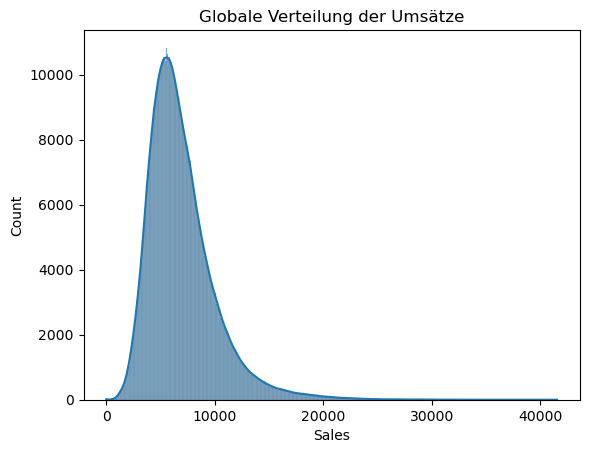

In [10]:
sns.histplot(sales_open_df['Sales'], kde=True).set(title="Globale Verteilung der Umsätze");

In [11]:
sales_mean = sales_open_df['Sales'].mean()
sales_std = sales_open_df['Sales'].std()
high_sales = sales_mean + 3*sales_std
sales_high_df = sales_open_df[sales_open_df['Sales'] > high_sales]

print("Durchschnittlicher Umsatz: {:.2f} Euro".format(sales_mean))
print("Standard Abweichung (wie weit die einzelnen Punkte im Durchschnitt vom Mittelwert entfernt sind): {:.2f} Euro".format(sales_std))
print("Anzahl der Datenpunkte, die Umsätze um mehr als drei Standardabweichungen über dem Durchschnitt aufweisen \n(>{:.2f} Euro): {}"
      .format(high_sales, len(sales_high_df)))

Durchschnittlicher Umsatz: 6955.51 Euro
Standard Abweichung (wie weit die einzelnen Punkte im Durchschnitt vom Mittelwert entfernt sind): 3104.21 Euro
Anzahl der Datenpunkte, die Umsätze um mehr als drei Standardabweichungen über dem Durchschnitt aufweisen 
(>16268.16 Euro): 13437


In [12]:
sales_outlier_stores = pd.DataFrame(sales_high_df.groupby('Store').size().sort_values(ascending=False)
                              .rename("NoDaysWithVeryHighSales"))
sales_outlier_stores[:10]

,NoDaysWithVeryHighSales
Store,
262,842
1114,734
562,684
817,667
251,614
513,544
788,512
383,488
842,449


Wir können feststellen, dass es Filialen gibt, die (sehr) oft Umsätze weit über dem Durchschnitt erzielen. Dies legt nahe, dass die Spitzenwerte der Umsätze mit den allgemeinen (vielleicht manchmal externen?) Bedingungen der jeweiligen Filialen zu tun haben.

Wie sieht nun die Beziehung zwischen Kundenanzahlen und den Umsätzen?

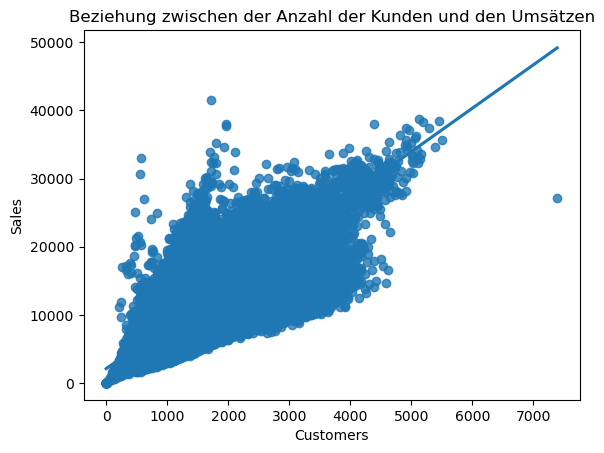

In [13]:
sns.regplot(x='Customers', y='Sales', data=sales_open_df).set(title="Beziehung zwischen der Anzahl der Kunden und den Umsätzen");

Wie erwartet, besteht eine positive Korrelation zwischen diesen beiden Variablen.  
Wie sieht die Verteilung con `Customers` an?

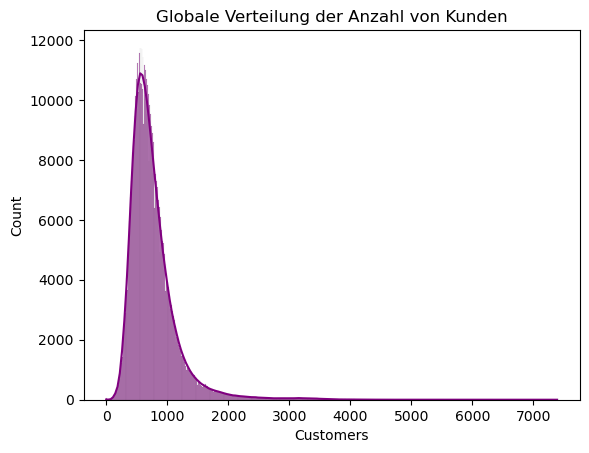

In [14]:
sns.histplot(sales_open_df['Customers'], kde=True, color='purple').set(title="Globale Verteilung der Anzahl von Kunden");

Die Verteilung der Anzahl der Kunden hat eine ähnliche Form wie die Verteilung der Umsätze. Intuitiv würde ich denken, dass Filialen mit einer sehr hohen Kundenzahl auch allgemein die mit sehr hohen Umsätzen sind.

In [15]:
customers_mean = sales_open_df['Customers'].mean()
customers_std = sales_open_df['Customers'].std()
high_customers = customers_mean + 3*customers_std
customers_high_df = sales_open_df[sales_open_df['Customers'] > high_customers]

print("Durchschnittliche Anzahl von Kunden: {:.2f}".format(customers_mean))
print("Standard Abweichung: {:.2f}".format(customers_std))
print("Anzahl der Datenpunkte, die Anzahl von Kunden um mehr als drei Standardabweichungen über dem Durchschnitt aufweisen \n(>{:.2f}): {}"
      .format(high_customers, len(customers_high_df)))

Durchschnittliche Anzahl von Kunden: 762.73
Standard Abweichung: 401.23
Anzahl der Datenpunkte, die Anzahl von Kunden um mehr als drei Standardabweichungen über dem Durchschnitt aufweisen 
(>1966.41): 15519


In [16]:
customers_outlier_stores = pd.DataFrame(customers_high_df.groupby('Store').size().sort_values(ascending=False)
                              .rename("NoDaysWithVeryHighNumberOfCustomers"))
customers_outlier_stores[:10]

,NoDaysWithVeryHighNumberOfCustomers
Store,
262,942
562,937
733,937
769,931
1097,844
259,791
1114,780
817,765
251,765


In [17]:
print("Anzahl der Flialen, die sehr hohe Umsätze erzielten: {}".format(len(sales_outlier_stores.index)))
print("Anzahl der Filialen, die eine sehr große Anzahl potenzieller Kunden hatten: {}".format(len(customers_outlier_stores.index)))
print("Anzahl der Filialen in beiden Kategorien: {}".format(len(sales_outlier_stores.index.intersection(customers_outlier_stores.index))))

Anzahl der Flialen, die sehr hohe Umsätze erzielten: 409
Anzahl der Filialen, die eine sehr große Anzahl potenzieller Kunden hatten: 133
Anzahl der Filialen in beiden Kategorien: 123


##### Globales Zeitreihenverhalten für Umsatz und Kundenzahl

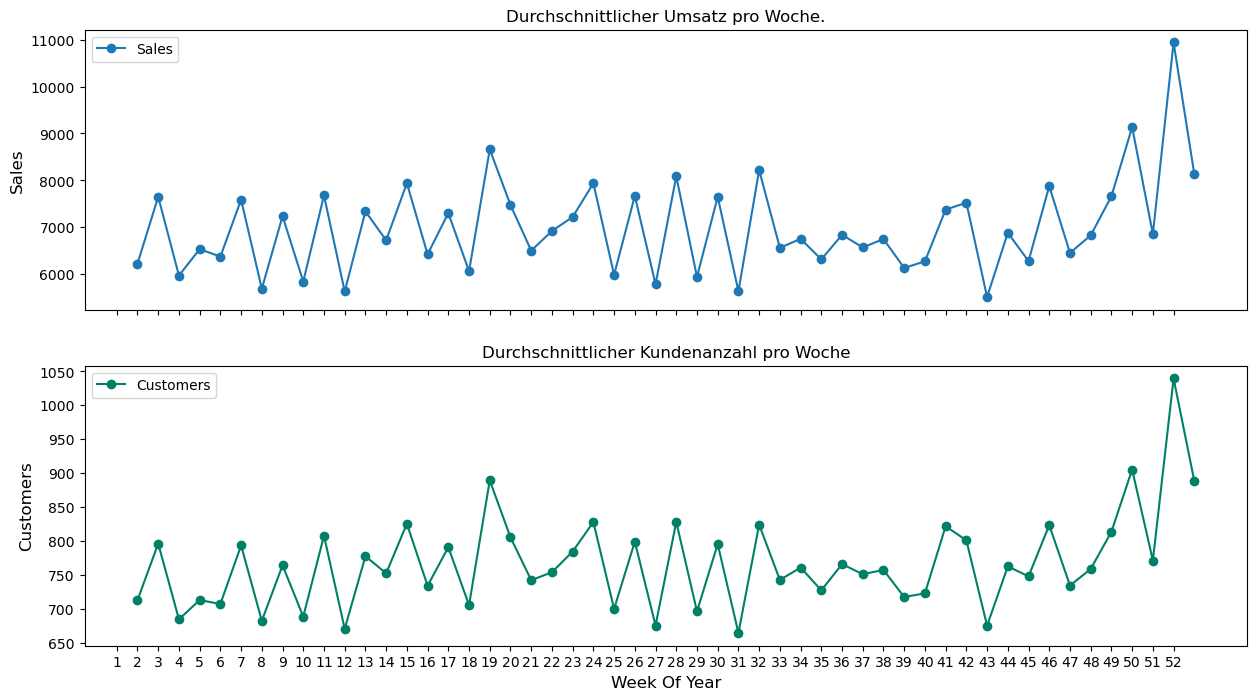

In [18]:
fig, axes = plt.subplots(2,1,sharex=True,figsize=(15,8))

# Create a WeekOfYear column and generate weekly time series for sales and customers
sales_open_df['WeekOfYear'] = sales_open_df['Date'].dt.isocalendar().week
average_sales = sales_open_df.groupby('WeekOfYear')["Sales"].mean()
average_customers = sales_open_df.groupby('WeekOfYear')["Customers"].mean()

# plot these time series
ax1 = average_sales.plot(legend=True, ax=axes[0], marker='o', title="Durchschnittlicher Umsatz pro Woche.")
ax1.set_xticks(range(len(average_sales)))
ax1.set_xticklabels(average_sales.index.tolist())
ax1.set_ylabel('Sales', size=12)

ax2 = average_customers.plot(legend=True, ax=axes[1], marker='o', colormap="summer", title="Durchschnittlicher Kundenanzahl pro Woche")
ax2.set_ylabel('Customers', size=12)

plt.xlabel('Week Of Year', size=12);

Wir stellen fest, dass sich beide Zeitreihen sehr ähnlich entwickeln, mit ausgeprägten Spitzen am Ende des Jahres.

##### DayOfWeek

In [19]:
sales_open_df.groupby('DayOfWeek')[['Customers', 'Sales']].mean()

,Customers,Sales
DayOfWeek,,
1,855.444984,8216.073074
2,769.986753,7088.113656
3,740.598876,6728.122978
4,755.569784,6767.310159
5,781.771639,7072.677012
6,660.177526,5874.840238
7,1441.532424,8224.723908


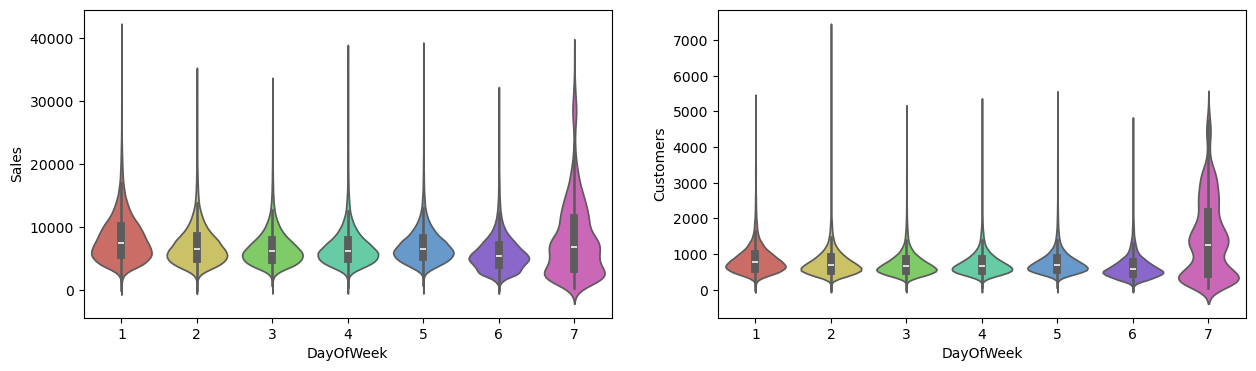

In [20]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.violinplot(x='DayOfWeek', y='Sales', data=sales_open_df, order=[1,2,3,4,5,6,7], ax=axis1, palette="hls")
sns.violinplot(x='DayOfWeek', y='Customers', data=sales_open_df, order=[1,2,3,4,5,6,7], ax=axis2, palette="hls");

Sonntags geöffnete Geschäfte haben viele Kunden und erzielen hohe Gewinne, aber das Verhältnis Kunden/Verkäufe ist nicht so hoch. Nach den Sonntagen sind die Montage die profitabelsten Tage.

##### Promo

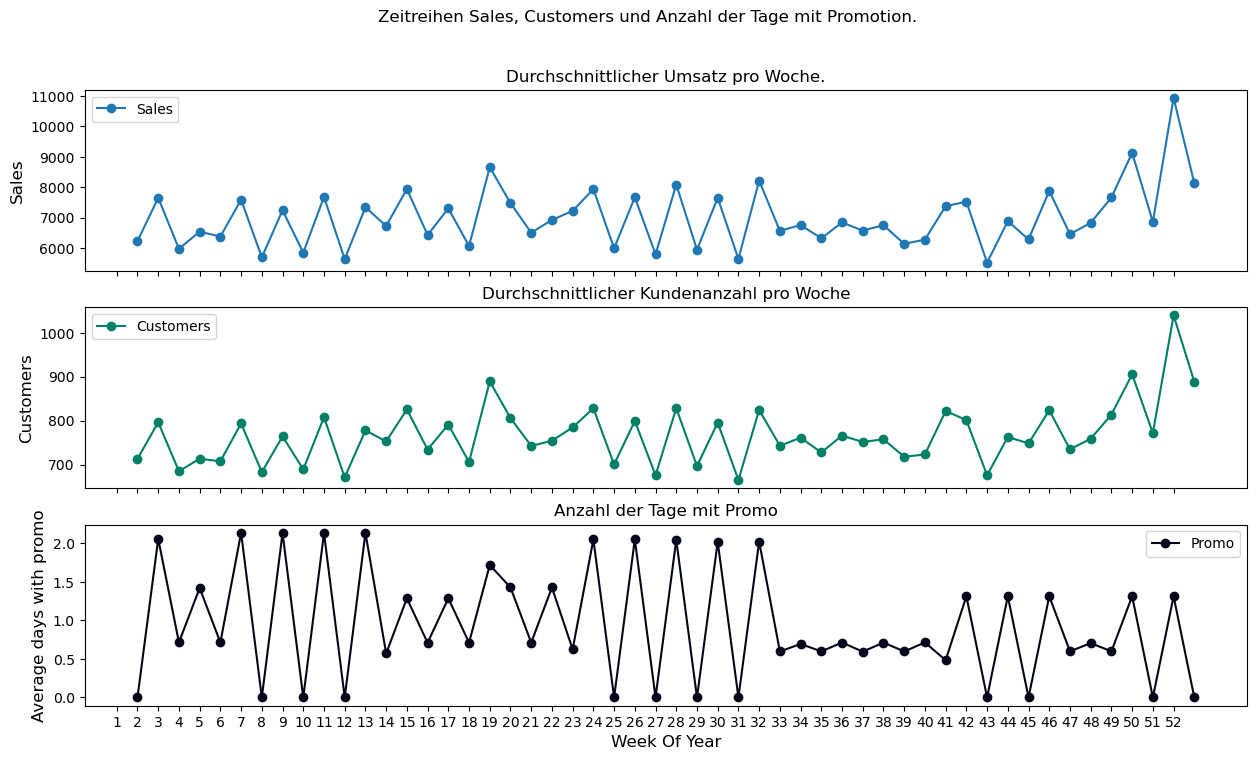

In [21]:
fig, axes = plt.subplots(3,1,sharex=True,figsize=(15,8))

sales_open_df['WeekOfYear'] = sales_open_df['Date'].dt.isocalendar().week

average_sales = sales_open_df.groupby('WeekOfYear')["Sales"].mean()
average_customers = sales_open_df.groupby('WeekOfYear')["Customers"].mean()
average_days_with_promo = (sales_open_df.groupby('WeekOfYear')["Promo"].sum())/(1115*7)

ax1 = average_sales.plot(legend=True, ax=axes[0], marker='o', title="Durchschnittlicher Umsatz pro Woche.")
ax1.set_xticks(range(len(average_sales)))
ax1.set_xticklabels(average_sales.index.tolist())
ax1.set_ylabel('Sales', size=12)

ax2 = average_customers.plot(legend=True, ax=axes[1], marker='o', colormap="summer", title="Durchschnittlicher Kundenanzahl pro Woche")
ax2.set_ylabel('Customers', size=12)

ax3 = average_days_with_promo.plot(legend=True, ax=axes[2], marker='o', colormap="rocket", title="Anzahl der Tage mit Promo")
ax3.set_ylabel('Average days with promo', size=12)


plt.xlabel('Week Of Year', size=12)
plt.suptitle("Zeitreihen Sales, Customers und Anzahl der Tage mit Promotion.");

Es scheint, dass die Zahl der Kunden und der Umsatz steigen, wenn es eine Werbeaktion gibt. Es scheint auch, dass Promo alle zwei Wochen in allen Filialen gleichzeitig aktiviert wird.

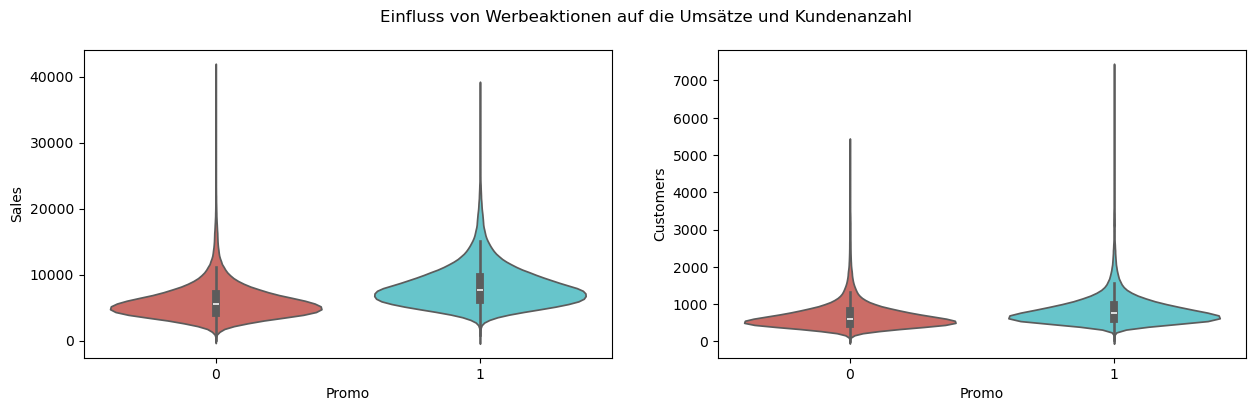

In [22]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.violinplot(x='Promo', y='Sales', data=sales_open_df, order=[0,1], ax=axis1, palette="hls")
sns.violinplot(x='Promo', y='Customers', data=sales_open_df, order=[0,1], ax=axis2, palette="hls")

plt.suptitle("Einfluss von Werbeaktionen auf die Umsätze und Kundenanzahl");

In [23]:
sales_open_df.groupby('Promo')[['Customers', 'Sales']].mean()

,Customers,Sales
Promo,,
0,696.856886,5929.407603
1,844.434401,8228.281239


##### Zusammenhang zwischen den verschiedenen Arten von Feiertagen und den Umsätzen/Besuchern

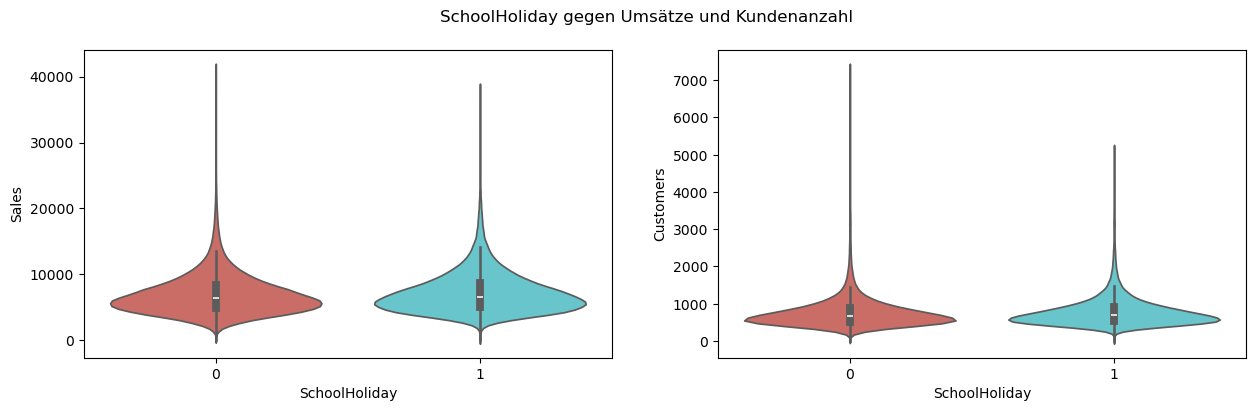

In [24]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.violinplot(x='SchoolHoliday', y='Sales', data=sales_open_df, order=[0,1], ax=axis1, palette="hls")
sns.violinplot(x='SchoolHoliday', y='Customers', data=sales_open_df, order=[0,1], ax=axis2, palette="hls")

plt.suptitle("SchoolHoliday gegen Umsätze und Kundenanzahl");

In [25]:
sales_open_df.groupby('SchoolHoliday')[['Customers', 'Sales']].mean()

,Customers,Sales
SchoolHoliday,,
0,757.833172,6896.782411
1,783.121090,7200.181650


In [26]:
sales_df['StateHoliday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

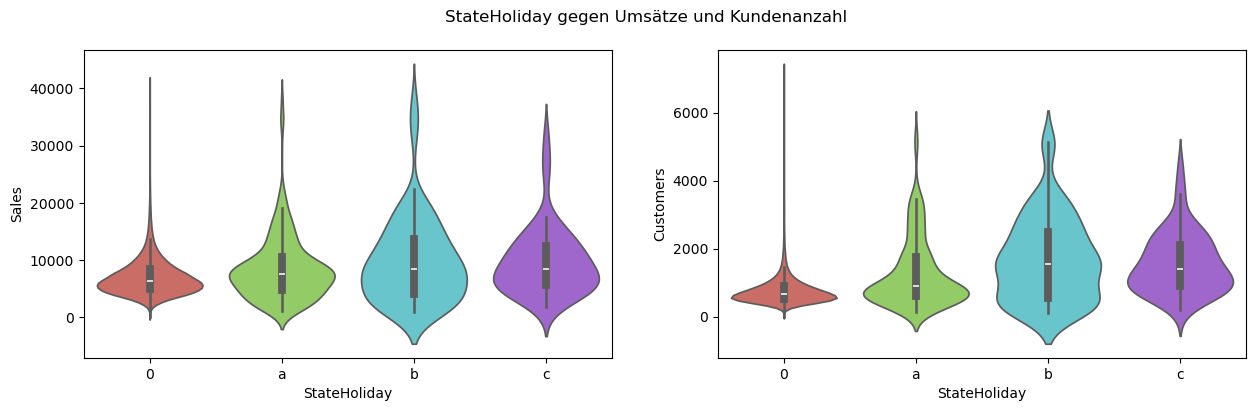

In [27]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.violinplot(x='StateHoliday', y='Sales', data=sales_open_df, order=sales_df['StateHoliday'].unique(), ax=axis1, palette="hls")
sns.violinplot(x='StateHoliday', y='Customers', data=sales_open_df, order=sales_df['StateHoliday'].unique(), ax=axis2, palette="hls")

plt.suptitle("StateHoliday gegen Umsätze und Kundenanzahl");

In [28]:
sales_open_df.groupby('StateHoliday')[['Customers', 'Sales']].mean()

,Customers,Sales
StateHoliday,,
0,762.076719,6953.515034
a,1279.172911,8487.471182
b,1686.889655,9887.889655
c,1569.225352,9743.746479


## Partieller Fazit
Eine Zusammenfassung der bisherigen Ergebnisse. 
- Wie erwartet, besteht eine positive Korrelation zwischen der Anzahl der Kunden und dem Umsatz. Optimal wäre es, wenn jeder Besucher einer Filiale ein effektiver Käufer wäre.
- Es gibt Filialen, die wahrscheinlich aufgrund ihrer Lage viel mehr Kunden empfangen und viel mehr Gewinn erwirtschaften als der Durchschnitt.
- Filialen,die sonntags offen haben erzielen höhe Gewinne, aber das Verhältnis Kunden/Verkäufe ist nicht so hoch.
- Offensichtlich gibt es mehr Kunden und mehr Umsatz, wenn eine Werbeaktion aktiv ist.
- In den Feiertagen gibt es allgemein mehr Kunden und Umsätze, besonders zu Osterferien und Weinnachten.